Original Graph with Extracted Data

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'LFP amplitude (μV)'}, xlabel='Electrode lateral distance (μm)', ylabel='Electrode depth (μm)'>)

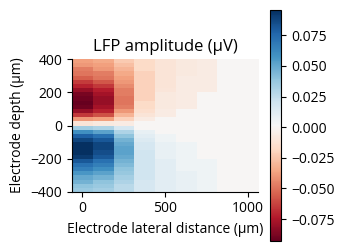

In [19]:
import wslfp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("mazzoni15-amp.csv", index_col=0).iloc[::-1]
wslfp.amplitude.plot_amp(df.values, extent=[-62.5, 1062.5, -400, 400])

Beta Distribution Extrapolation

/tmp/ipykernel_4061/2767919588.py:22: OptimizeWarning: Covariance of the parameters could not be estimated
  result = curve_fit(


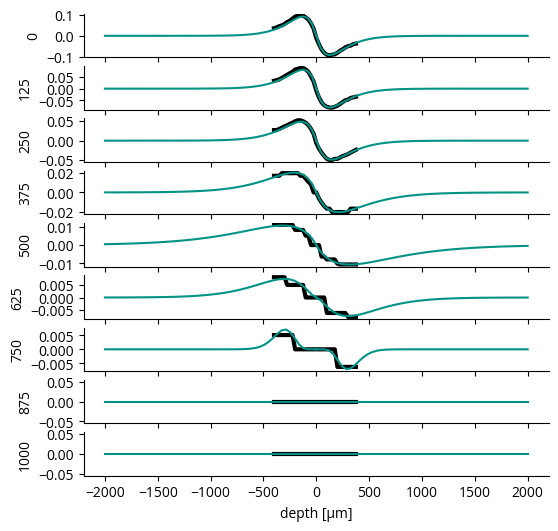

In [34]:
from scipy.interpolate import LinearNDInterpolator
from scipy.stats import beta
from scipy.optimize import curve_fit

pop_radius_um = 250  # um
f = df.values
r = df.columns.astype(float).to_numpy() * pop_radius_um
d = df.index.astype(float).to_numpy()

a = np.zeros_like(r)
b = np.zeros_like(r)
loc = np.zeros_like(r)
scale = np.zeros_like(r)
dmax = np.zeros_like(r)


def f_beta(r, a, b, scale, dmax):
    return beta.pdf(r / dmax, a, b, loc=0, scale=scale)


def opt(amp_values, p0):
    result = curve_fit(
        f_beta, d[16:], -amp_values[16:], method="lm", maxfev=100000, p0=p0
    )
    a, b, scale, dmax = result[0]
    return a, b, scale, dmax


p0 = [2.92851034e00, 2.23967397e07, 6.45591424e07, 2.91873521e01]
d_eval = np.linspace(0, 2000)
rdf_samples = np.empty((0, 3))
fig, axs = plt.subplots(len(r), 1, figsize=(6, 6), sharex=True)
for i in range(len(r)):
    axs[i].plot(d, f[:, i], c="k", lw=3)

    a[i], b[i], scale[i], dmax[i] = opt(f[:, i], p0)
    f_i = -beta.pdf(d_eval / dmax[i], a[i], b[i], scale=scale[i])
    axs[i].plot(d_eval, f_i, c="xkcd:teal")
    axs[i].plot(-d_eval, -f_i, c="xkcd:teal")
    axs[i].set(ylabel=f"{r[i]:.0f}")

    axs[i].set(xlabel="depth [μm]")
    p0 = [a[i], b[i], scale[i], dmax[i]]

    rdf_i = np.column_stack(np.broadcast_arrays(r[i], d_eval, f_i))
    rdf_samples = np.concatenate([rdf_samples, rdf_i])

np.save("../wslfp/mazzoni15-rdf.npy", rdf_samples)
np.savez_compressed(
    "../wslfp/mazzoni15-beta-params.npz", a=a, b=b, scale=scale, dmax=dmax, rslices=r
)

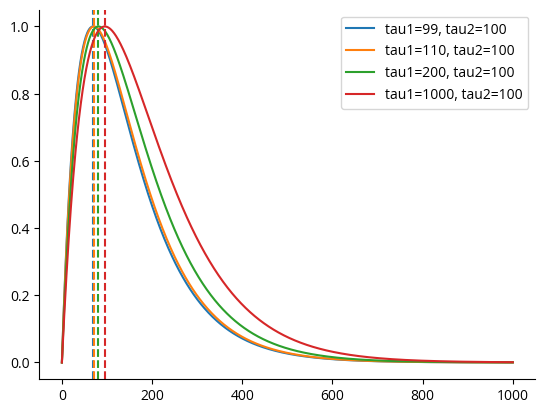

In [131]:
def doub_exp(x, tau1, tau2, normalize=False):
    y = (1 - np.exp(-x / tau1)) * np.exp(-x / tau2)
    if normalize:
        y = y / np.max(y)
    return y


x = np.linspace(0, 1000, 1000)
tau1_values = [100]
tau1_values = np.linspace(10, 100, 5)
tau1_values = [99, 110, 200, 1000]
tau2_values = np.linspace(10, 100, 5)
tau2_values = [100]
fig, ax = plt.subplots()
for tau1 in tau1_values:
    for tau2 in tau2_values:
        y = doub_exp(x, tau1, tau2, True)
        xmax = x[np.argmax(y)]
        ax.plot(x, y, label=f"tau1={tau1}, tau2={tau2}")
        # get last used color in cycler
        color = ax.get_lines()[-1].get_color()
        ax.axvline(xmax, color=color, linestyle="--")
ax.legend()

1.0839243238751202
1.154398570407767
1.3333333333333333
1.4873869585911472
1.5773675300856045


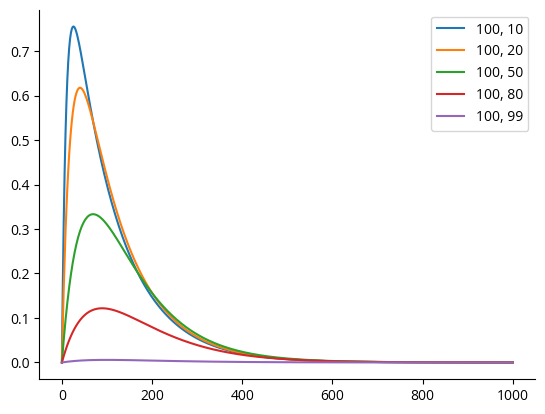

In [114]:
def biexp(x, tau1, tau2, normalize=True):
    if normalize:
        norm_factor = 1 / (
            (tau2 / tau2) ** (tau2 / (tau1 - tau2))
            - (tau2 / tau1) ** (tau1 / (tau1 - tau2))
        )
        print(norm_factor)
        return norm_factor * (np.exp(-x / tau1) - np.exp(-x / tau2))
    else:
        return np.exp(-x / tau1) - np.exp(-x / tau2)


x = np.linspace(0, 1000, 500)
fig, ax = plt.subplots()

tau2_values = [10, 20, 50, 80, 99]
tau1 = 100

for tau2 in tau2_values:
    ax.plot(x, biexp(x, tau1, tau2, True), label=f"{tau1}, {tau2}")

ax.legend()

[109.8088275  125.77377195 627.69018902 121.5773506   -1.96412043]


/tmp/ipykernel_27238/3284847520.py:8: RuntimeWarning: divide by zero encountered in divide
  norm_factor = 1 / (


(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'LFP amplitude (μV)'}, xlabel='Electrode lateral distance (μm)', ylabel='Electrode depth (μm)'>)

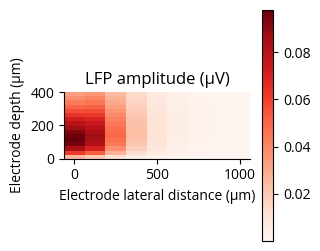

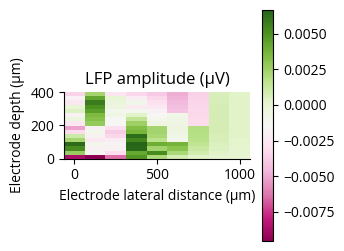

In [115]:
rr_opt, dd_opt = np.meshgrid(r, -d[16:])


def f_biexp(r_d, tau1, tau2, tau2_inv_decay, rdecay, scale):
    """tau1 is fall time, tau2 is rise time and should get bigger with horizontal distance"""
    r, d = r_d
    tau2 = 1 / (1 / tau2 * np.exp(-r / tau2_inv_decay))
    norm_factor = 1 / (
        (tau2 / tau2) ** (tau2 / (tau1 - tau2))
        - (tau2 / tau1) ** (tau1 / (tau1 - tau2))
    )
    norm_factor = 1
    f = (
        norm_factor
        * scale
        * (np.exp(-d / tau1) - np.exp(-d / tau2))
        * np.exp(-r / rdecay)
    )
    return f


def f_biexp_opt(r_d, tau1, tau2, tau2_inv_decay, rdecay, scale):
    return f_biexp(r_d, tau1, tau2, tau2_inv_decay, rdecay, scale).flatten()


opt_result = curve_fit(
    f_biexp_opt,
    (rr_opt, dd_opt),
    f[16:].flatten(),
    # method="lm",
    maxfev=100000,
    p0=[130, 120, pop_radius_um, pop_radius_um, 1e4],
)
print(opt_result[0])
tau1, tau2, tau1_decay, rdecay, scale = opt_result[0]
# assert tau1 > tau2
# assert scale > 0

f_result = f_biexp((rr_opt, dd_opt), tau1, tau2, tau1_decay, rdecay, scale)
# print(f_result.shape)
extent = [-62.5, 1062.5, 0, 400]
wslfp.amplitude.plot_amp(
    f_result,
    extent=extent,
    cmap="Reds",
)
wslfp.amplitude.plot_amp(
    f_result - f[16:],
    extent=extent,
    cmap="PiYG",
)

Not quite...let's go per-slice:

/tmp/ipykernel_27238/3749630343.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  opt_result = curve_fit(
/tmp/ipykernel_27238/3749630343.py:11: RuntimeWarning: divide by zero encountered in divide
  return scale * (f / np.max(f))
/tmp/ipykernel_27238/3749630343.py:11: RuntimeWarning: invalid value encountered in divide
  return scale * (f / np.max(f))


125.77377 118.24228874065659 0.09639471169634677
125.77377 117.20406063647434 0.08752597666906214
125.77377 125.76943572908338 0.05463340632886363
125.77377 125.7657035987679 0.028200027063000076
125.77377 125.77196512265795 0.021087400692085857
125.77377 19826138223.907787 0.0006961895122394653
125.77377 6.03558267716492e+16 0.00039080236949719634


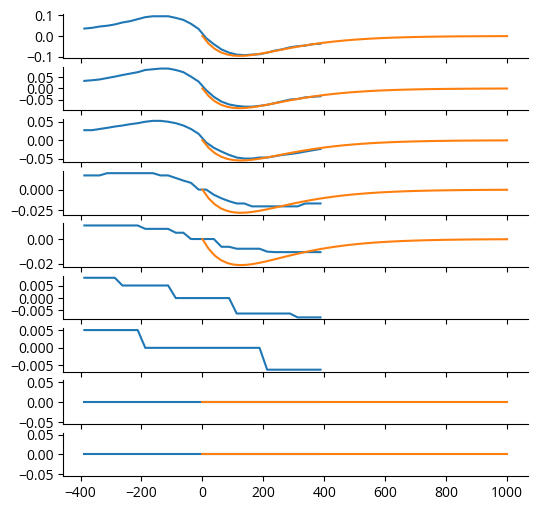

In [180]:
tau1_arr = np.ones_like(r)
tau2_arr = np.ones_like(r)
scale_arr = np.zeros_like(r)


def f_biexp_slice(d, tau1, tau2, scale):
    """tau1 is fall time, tau2 is rise time and should get bigger with horizontal distance"""
    tau1 = 125.77377
    # tau1 = 200
    f = np.exp(-d / tau1) - np.exp(-d / tau2)
    return scale * (f / np.max(f))


def f_doub_exp_slice(d, tau1, tau2, scale):
    tau1 = 125.77377
    f = (1 - np.exp(-d / tau1)) * np.exp(-d / tau2)
    return scale * (f / np.max(f))


opt_func = f_biexp_slice

p0 = [125.77377, np.log(120), 1e4]
for i in range(len(r) - 2):
    # for i in [0]:
    # opt_result =
    opt_result = curve_fit(
        opt_func, -d[16:], f[16:, i], method="lm", maxfev=1000, p0=p0
    )
    print(*opt_result[0])
    tau1_arr[i], tau2_arr[i], scale_arr[i] = opt_result[0]
    # # print(tau2, scale)
    # # tau2_arr[i] = tau2
    # # scale_arr[i] = scale
    p0 = opt_result[0]


fig, axs = plt.subplots(len(r), 1, figsize=(6, 6), sharex=True)
for i in range(len(r)):
    axs[i].plot(d, f[:, i])
    x = np.linspace(0, 1000)
    axs[i].plot(x, -opt_func(x, tau1_arr[i], tau2_arr[i], scale_arr[i]))

In [143]:
f[2, 16:]

array([], dtype=float64)

[1. 1. 1. 1. 1. 1.]


/tmp/ipykernel_27238/1101266073.py:7: RuntimeWarning: divide by zero encountered in divide
  return d1 / d + d2 / d**2 + r1 / r + r2 / r**2 + dist1 / dist + dist2 / dist**2
/tmp/ipykernel_27238/1101266073.py:14: OptimizeWarning: Covariance of the parameters could not be estimated
  opt_result = curve_fit(


(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'LFP amplitude (μV)'}, xlabel='Electrode lateral distance (μm)', ylabel='Electrode depth (μm)'>)

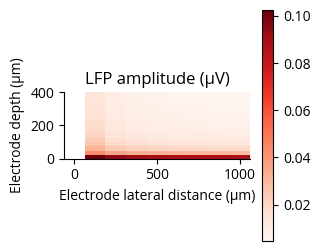

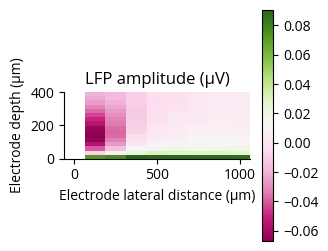

In [76]:
rr_opt, dd_opt = np.meshgrid(r, -d[16:])


def f_dist(r_d, d1, d2, r1, r2, dist1, dist2):
    r, d = r_d
    dist = np.sqrt(r**2 + d**2)
    return d1 / d + d2 / d**2 + r1 / r + r2 / r**2 + dist1 / dist + dist2 / dist**2


def f_dist_opt(r_d, d1, d2, r1, r2, dist1, dist2):
    return f_dist(r_d, d1, d2, r1, r2, dist1, dist2).flatten()


def f_exp_dist(r_d, d1, d2, r1, r2, dist1, dist2):
    r, d = r_d
    dist = np.sqrt(r**2 + d**2)
    return


def f_exp_dist_opt(r_d, d1, d2, r1, r2, dist1, dist2):
    return f_dist(r_d, d1, d2, r1, r2, dist1, dist2).flatten()


opt_result = curve_fit(
    f_dist_opt,
    (rr_opt, dd_opt),
    f[16:].flatten(),
    method="lm",
    maxfev=100000,
    # p0=[130, 120, pop_radius_um, pop_radius_um, 1e4],
)
print(opt_result[0])
d1, d2, r1, r2, dist1, dist2 = opt_result[0]

f_result = f_dist((rr_opt, dd_opt), d1, d2, r1, r2, dist1, dist2)
extent = [-62.5, 1062.5, 0, 400]
wslfp.amplitude.plot_amp(
    f_result,
    extent=extent,
    cmap="Reds",
)
wslfp.amplitude.plot_amp(
    f_result - f[16:],
    extent=extent,
    cmap="PiYG",
)

Interpolation of each Beta Distribution

In [3]:
from scipy.interpolate import LinearNDInterpolator

arrB = []
xcount = 0

p0 = [2.92851034e00, 2.23967397e07, 6.45591424e07, 2.91873521e01]
for i in range(len(x0)):
    a[i], b[i], scale[i], ymax[i] = opt(z0[:, i], p0)
    ampB = -beta.pdf(np.linspace(0, 2000) / ymax[i], a[i], b[i], scale=scale[i])
    for n in range(len(ampB)):
        arrB.append([x0[xcount], np.linspace(0, 2000)[n], ampB[n]])
    xcount += 1
    p0 = [a[i], b[i], scale[i], ymax[i]]


arrB = np.array(arrB).astype("float")
r = arrB[:, 0]
d = arrB[:, 1]
f = arrB[:, 2]


X = np.linspace(0, 6, 1000)
Y = np.linspace(0, 900, 1000)
x1, y1 = np.meshgrid(X, Y)


f1 = LinearNDInterpolator(list(zip(r, d)), f)
# f = interp2d(x,y,zlist)


fnew = f1(x1, y1)
# fnew = f(xlist,ylist)

plt.imshow(fnew, cmap="bwr_r")
plt.colorbar()
plt.clim(-0.1, 0.1)
plt.xlabel("Electrode Position")
plt.ylabel("Depth")
plt.title("LFP Amplitude")
plt.ylim(plt.ylim()[::-1])
plt.yticks(range(len(Y)), Y.round(0))
plt.xticks(range(len(X)), X.round(0))
plt.locator_params(axis="x", nbins=6)
plt.locator_params(axis="y", nbins=9)


plt.show()

NameError: name 'x0' is not defined